In [8]:
# Imports
import tifffile
import numpy as np

from skimage.transform import SimilarityTransform

from scripts.config_model import save_experiment_config, tree
from scripts.sample_db import SampleDB
from scripts.utils.image_utils import load_tiff_as_hyperstack, save_array_as_hyperstack_tiff, bin_image, coarse_plane_detection_in_stack, slice_into_uniform_tiles,fine_plane_detection_in_stack_by_tiling,plot_matched_plane_and_cropped_slice, plot_image_correlation, warp_stack_to_plane
import os
import matplotlib.pyplot as plt
plt.set_cmap('binary')

from skimage.exposure import match_histograms, equalize_adapthist, rescale_intensity



<Figure size 640x480 with 0 Axes>

In [9]:

def plane_detection_with_iterative_alignment(plane, stack, equalize=True, binning=True, plot=True, nx=2, ny=3, tiles_filter=None, thickness_values=None):
    """
    Detects a plane within a 3D image stack using iterative alignment of tiles.

    This function performs plane detection in a 3D image stack by iteratively aligning tiles
    from a 2D plane image to the stack. It uses a combination of image processing techniques
    including adaptive histogram equalization, binning, coarse detection, and fine alignment
    using tile-based correlation.

    Parameters:
    -----------
    plane : numpy.ndarray
        2D array representing the plane to be detected in the stack.
    stack : numpy.ndarray
        3D array representing the image stack to search for the plane.
    equalize : bool, optional (default=True)
        If True, apply adaptive histogram equalization to the images.
    binning : bool, optional (default=True)
        If True, apply binning to reduce image size for initial coarse detection.
    plot : bool, optional (default=True)
        If True, generate plots at various stages of the detection process.
    nx : int, optional (default=2)
        Number of tiles in the x-direction for fine alignment.
    ny : int, optional (default=3)
        Number of tiles in the y-direction for fine alignment.
    tiles_filter : numpy.ndarray, optional (default=None)
        2D boolean array to select which tiles to use in the alignment process.
        If None, a default filter is used.
    thickness_values : list of int, optional (default=None)
        List of thickness values to use in iterative alignment.
        If None, default values [100, 50, 50, 30, 30, 20] are used.

    Returns:
    --------
    current_tform : numpy.ndarray
        4x4 transformation matrix representing the final alignment.
    all_transformation_matrices : list of numpy.ndarray
        List of all intermediate transformation matrices.

    Notes:
    ------
    The function performs the following main steps:
    1. Image preprocessing (equalization and binning)
    2. Coarse detection of the plane in the stack
    3. Iterative fine alignment using tile-based correlation
    4. Transformation estimation and refinement

"""

    # Set default tiles_filter if not provided
    if tiles_filter is None:
        tiles_filter = np.array([[1, 1],
                                 [1, 1],
                                 [0, 0]])

    # Equalization
    if equalize:
        try:
            equalized_plane = equalize_adapthist(plane, clip_limit=0.03)
        except:
            equalized_plane = equalize_adapthist(rescale_intensity(plane, out_range=(0, 1)), clip_limit=0.03)
        
        equalized_stack = np.array([
            equalize_adapthist(rescale_intensity(slice, out_range=(0, 1)), clip_limit=0.03)
            for slice in stack
        ])
    else:
        equalized_plane = plane
        equalized_stack = stack

    # Binning
    if binning:
        binned_plane = bin_image(equalized_plane)
        binned_stack = np.array([bin_image(slice) for slice in equalized_stack])
    else:
        binned_plane = equalized_plane
        binned_stack = equalized_stack

    # Coarse detection
    max_corr_coarse, max_position_coarse, _ = coarse_plane_detection_in_stack(binned_plane, binned_stack, plot_all_correlations=plot)

    if plot:
        plot_matched_plane_and_cropped_slice(binned_stack, binned_plane, max_position_coarse)
        
    if thickness_values is None:
        thickness_values = [100, 50, 50, 30, 30, 20, 20]

    # Slice into tiles
    tiles, tile_size, adj_image_size = slice_into_uniform_tiles(equalized_plane, nx, ny, plot=plot)

    x = np.arange(tile_size[1]//2, adj_image_size[1], tile_size[1])
    y = np.arange(tile_size[0]//2, adj_image_size[0], tile_size[0])
    xv, yv = np.meshgrid(x, y)

    points_filter = np.where(tiles_filter.flatten()==1)

    all_transformation_matrices = [np.eye(4)]
    current_tform = np.eye(4)

    # Iterative alignment of tiles
    for thickness in thickness_values:
        print(f"Thickness {thickness}")
        if len(all_transformation_matrices) == 1:
            min_z_range = max(0, max_position_coarse[0] - thickness//2)
            max_z_range = min(stack.shape[0], max_position_coarse[0] + thickness//2)
            best_plane_matrix, all_correlations_matrix = fine_plane_detection_in_stack_by_tiling(
                tiles, equalized_stack, tiles_filter, z_range=[min_z_range, max_z_range])
            
            if plot:
                plot_image_correlation(tiles, equalized_stack, best_plane_matrix, all_correlations_matrix)

            lm_plane_points = np.array([(0, yv[i,j], xv[i,j])
                                for i in range(ny) for j in range(nx)])
        else:
            interpolated_stack = warp_stack_to_plane(stack, plane, SimilarityTransform(current_tform), thickness)

            best_plane_matrix, all_correlations_matrix = fine_plane_detection_in_stack_by_tiling(
                tiles, interpolated_stack, tiles_filter)
            
            if plot:
                plot_image_correlation(tiles, interpolated_stack, best_plane_matrix, all_correlations_matrix)
           
            lm_plane_points = np.array([(interpolated_stack.shape[0]//2, yv[i,j], xv[i,j])
                                        for i in range(ny) for j in range(nx)])
        
        lm_stack_points = np.array([best_plane_matrix[i,j] for i in range(ny) for j in range(nx)])
        
        source = lm_plane_points[points_filter]
        target = lm_stack_points[points_filter]

        tform = SimilarityTransform()
        tform.estimate(source, target)

        all_transformation_matrices.append(tform.params)
        current_tform = np.linalg.multi_dot(all_transformation_matrices[::-1])


    # Plot the last matched slice with plane

    last_matched_slice = warp_stack_to_plane(stack, plane, SimilarityTransform(current_tform), thickness_values[-1])[thickness_values[-1]//2]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(plane, cmap='gray')
    ax1.set_title('Original Plane')
    ax1.axis('off')
    
    ax2.imshow(last_matched_slice, cmap='gray')
    ax2.set_title('Last Matched Slice')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

    return current_tform, all_transformation_matrices

In [10]:
# Step 1: Load the sample database
db_path = r'\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\sample_db.csv'
sample_db = SampleDB()
sample_db.load(db_path)
print(sample_db)

SampleDB(sample_ids=['20220426_RM0008_130hpf_fP1_f3', '20220118_RM0012_124hpf_fP8_f2', '20220427_RM0008_126hpf_fP3_f3'])


In [11]:
# Step 2: Load experiment configuration
sample_id = '20220426_RM0008_130hpf_fP1_f3'
exp = sample_db.get_sample(sample_id)

In [12]:
# Step 3: Making shortcuts of sample parameters/information
sample = exp.sample
root_path = exp.paths.root_path
trials_path = exp.paths.trials_path
anatomy_path = exp.paths.anatomy_path
em_path = exp.paths.em_path
n_planes = exp.params_lm.n_planes
n_frames = exp.params_lm.n_frames
n_slices = exp.params_lm.lm_stack_range
doubling = 2 if exp.params_lm.doubling else 1

# Calculating number of frames per trial 
n_frames_trial = n_frames // n_planes
exp.params_lm["n_frames_trial"] = n_frames_trial

# Getting paths of the trial acquisitions
raw_trial_paths = os.listdir(os.path.join(trials_path, "raw"))
n_trials = len(raw_trial_paths)
exp.params_lm["n_trials"] = n_trials
ignore_until_frame = exp.params_lm.shutter_delay_frames  # edit if you want to avoid summing out motor movements at the beginning of acquisition

# Define the path for the preprocessed folder
processed_folder = os.path.join(trials_path, "processed")
os.makedirs(processed_folder, exist_ok=True)

ref_images_path = os.path.join(processed_folder, f"sum_raw_trials_{sample.id}.tif")

In [13]:
# Step 4: Load planes and stack
lm_planes = tifffile.imread(ref_images_path)
print(lm_planes.shape)
#TODO: Make a way to automatize file finding  
#lm_stack = load_tiff_as_hyperstack(os.path.join(anatomy_path,"processed",os.listdir(os.path.join(anatomy_path, "processed"))[0]))
lm_stack = load_tiff_as_hyperstack(os.path.join(anatomy_path, "raw", "20220426_RM0008_130hpf_fP1_f3_anatomyGFRF_001_.tif"), n_channels=2)[0]
print(lm_stack.shape)


(8, 24, 256, 512)
\\tungsten-nas.fmi.ch\tungsten\scratch\gfriedri\montruth\2P_RawData\2022-04-26\f3\anatomy\raw\20220426_RM0008_130hpf_fP1_f3_anatomyGFRF_001_.tif loaded.
(150, 512, 512)


Plane 0
Original image size: 256x512
Tile size: 85x256
Adjusted image size for perfect slicing: 255x512
Number of tiles: 6
Thickness 100
Thickness 50
Thickness 50
Thickness 30
Thickness 30
Thickness 20
Thickness 20


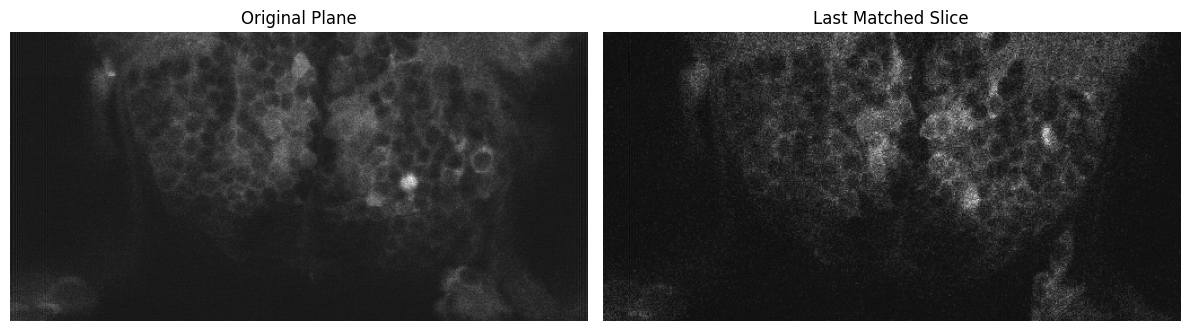

Plane 1
Original image size: 256x512
Tile size: 85x256
Adjusted image size for perfect slicing: 255x512
Number of tiles: 6
Thickness 100
Thickness 50
Thickness 50
Thickness 30
Thickness 30
Thickness 20
Thickness 20


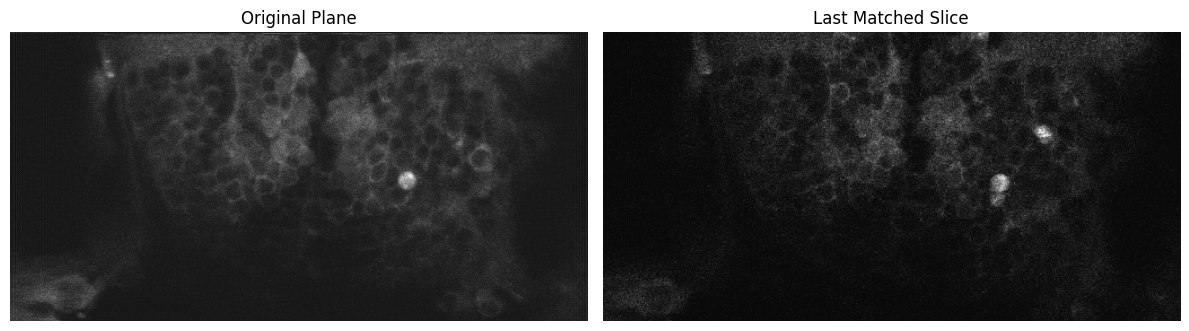

Plane 2
Original image size: 256x512
Tile size: 85x256
Adjusted image size for perfect slicing: 255x512
Number of tiles: 6
Thickness 100
Thickness 50
Thickness 50
Thickness 30
Thickness 30
Thickness 20
Thickness 20


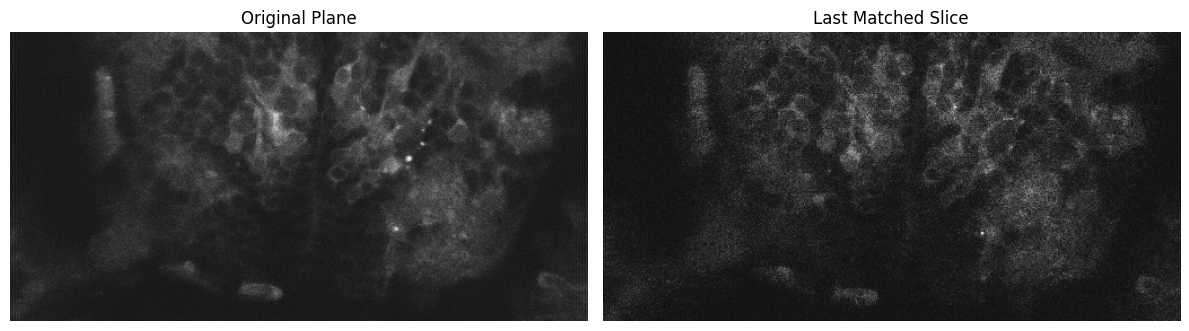

Plane 3
Original image size: 256x512
Tile size: 85x256
Adjusted image size for perfect slicing: 255x512
Number of tiles: 6
Thickness 100
Thickness 50
Thickness 50
Thickness 30
Thickness 30
Thickness 20
Thickness 20


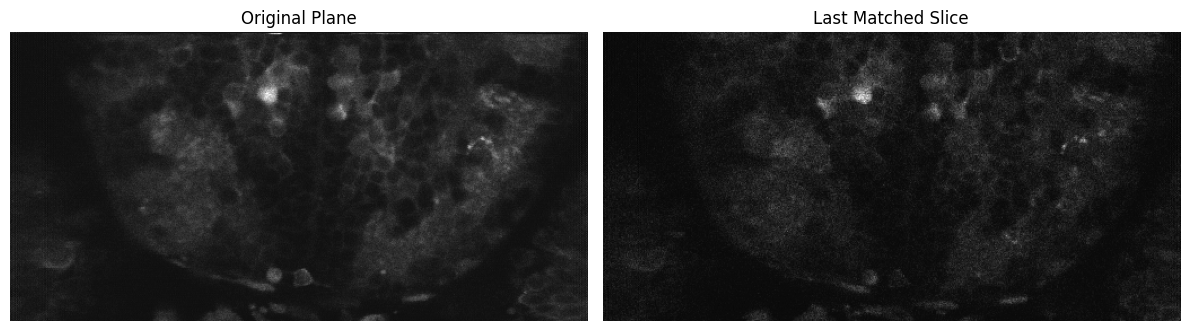

Plane 4
Original image size: 256x512
Tile size: 85x256
Adjusted image size for perfect slicing: 255x512
Number of tiles: 6
Thickness 100
Thickness 50
Thickness 50
Thickness 30
Thickness 30
Thickness 20
Thickness 20


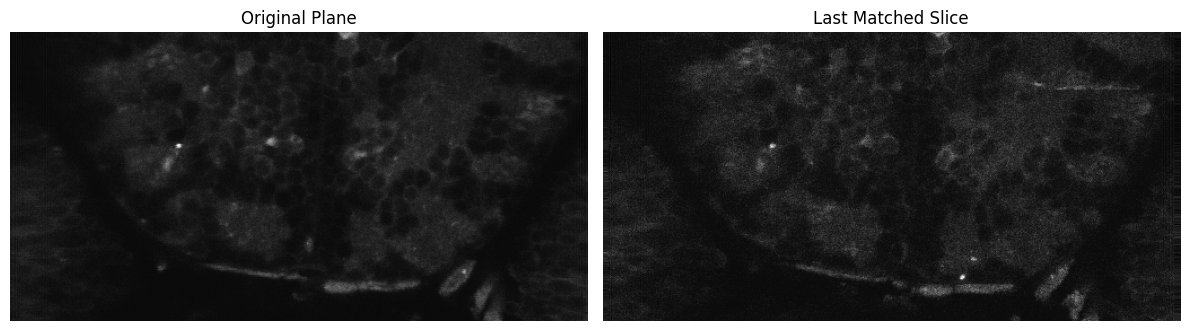

Plane 5
Original image size: 256x512
Tile size: 85x256
Adjusted image size for perfect slicing: 255x512
Number of tiles: 6
Thickness 100
Thickness 50
Thickness 50
Thickness 30
Thickness 30
Thickness 20
Thickness 20


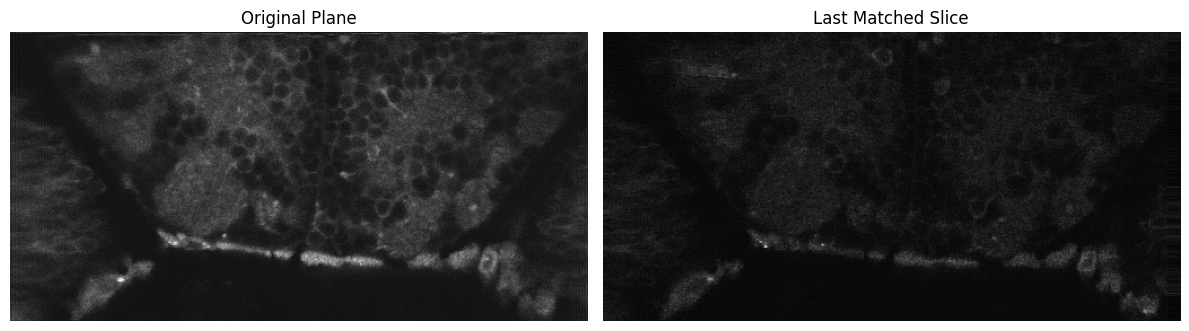

Plane 6
Original image size: 256x512
Tile size: 85x256
Adjusted image size for perfect slicing: 255x512
Number of tiles: 6
Thickness 100
Thickness 50
Thickness 50
Thickness 30
Thickness 30
Thickness 20
Thickness 20


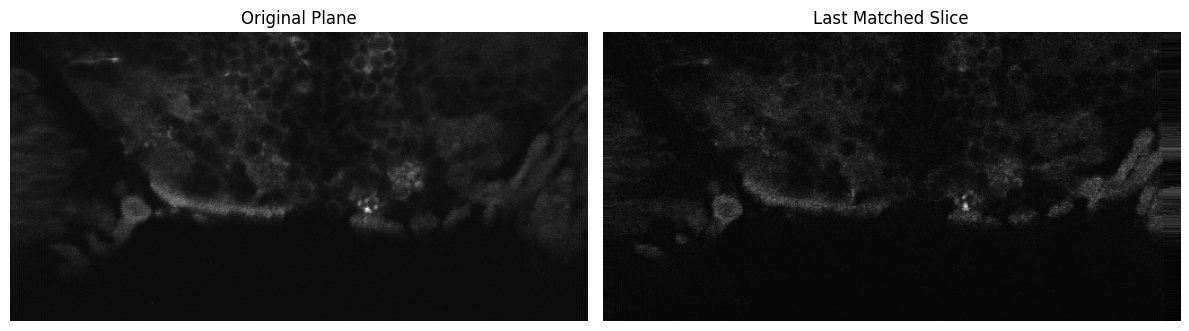

Plane 7
Original image size: 256x512
Tile size: 85x256
Adjusted image size for perfect slicing: 255x512
Number of tiles: 6
Thickness 100
Thickness 50
Thickness 50
Thickness 30
Thickness 30
Thickness 20
Thickness 20


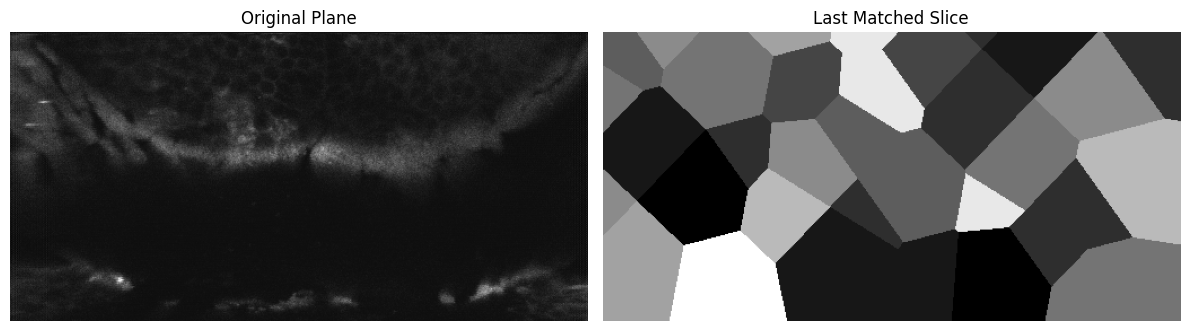

In [14]:
# Step 5: Find planes in stack 
for ii, lm_plane in enumerate(lm_planes[:,-1]):
    print(f"Plane {ii}")
    final_transform, all_transformation_matrices = plane_detection_with_iterative_alignment(lm_plane, lm_stack, equalize=True, binning=True, plot=False, nx=2, ny=3, tiles_filter=None, thickness_values= None)
    np.save(os.path.join(trials_path,"processed", f"registration_tform_lm_plane0{ii}_lm_stack.npy"), final_transform)
    